# XGboosting

## Imports


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import xgboost as xgb
from util import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split,cross_val_score,cross_validate
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix ,f1_score


NUM_FOLDS = 10


## Reading the data


In [4]:
X, X_test, y, y_test = get_data(path='../data/train_pca_20.csv')
# standardize the data
X = standardize_features(X)
X_test = standardize_features(X_test)

In [5]:
X.columns

Index(['pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8',
       'pca9', 'pca10', 'pca11', 'pca12', 'pca13', 'pca14', 'pca15', 'pca16',
       'pca17', 'pca18', 'pca19'],
      dtype='object')

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Training the model


### Parameters for Tree Booster

- **eta** *[default=0.3, alias: learning_rate]*:
  - Step size shrinkage used in updates to prevent overfitting. It shrinks the feature weights after each boosting step to make the process more conservative.
  - Range: [0,1]

- **gamma** *[default=0, alias: min_split_loss]*:
  - Minimum loss reduction required to make a further partition on a leaf node of the tree. Higher values make the algorithm more conservative.
  - Range: [0,∞]

- **max_depth** *[default=6]*:
  - Maximum depth of a tree. Increasing it makes the model more complex and more likely to overfit. 0 indicates no limit on depth.
  - Range: [0,∞]

- **min_child_weight** *[default=1]*:
  - Minimum sum of instance weight needed in a child node. If partitioning a leaf results in a child with a sum of instance weight less than this, further partitioning is halted.
  - Range: [0,∞]

- **max_delta_step** *[default=0]*:
  - Maximum delta step allowed for each leaf output. Values >0 make the update step more conservative.
  - Range: [0,∞]

- **subsample** *[default=1]*:
  - Subsample ratio of the training instances. Setting it to 0.5 means randomly sampling half of the training data prior to growing trees.
  - Range: (0,1]

- **sampling_method** *[default=uniform]*:
  - The method to sample training instances. 
  - Choices: uniform (equal probability for each instance), gradient_based (probability proportional to the absolute value of gradients).

- **colsample_bytree, colsample_bylevel, colsample_bynode** *[default=1]*:
  - Subsampling of columns.
  - Range: (0, 1]
  - `colsample_bytree`: Subsample ratio of columns when constructing each tree.
  - `colsample_bylevel`: Subsample ratio of columns for each level.
  - `colsample_bynode`: Subsample ratio of columns for each node (split).

- **lambda** *[default=1, alias: reg_lambda]*:
  - L2 regularization term on weights. Increasing it makes the model more conservative.
  - Range: [0,∞]

- **alpha** *[default=0, alias: reg_alpha]*:
  - L1 regularization term on weights. Increasing it makes the model more conservative.
  - Range: [0,∞]

- **tree_method** *[default=auto]*:
  - The tree construction algorithm used in XGBoost.
  - Choices: auto, exact, approx, hist.

- **scale_pos_weight** *[default=1]*:
  - Control the balance of positive and negative weights, useful for unbalanced classes.

In [7]:
params = {
    "device": "cuda",
    # "tree_method": "gpu_hist"
    "tree_method": "hist"
}
xgb_model = xgb.XGBClassifier(**params)
# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred = xgb_model.predict(X_train)

# Compute training error
training_error = np.mean(y_train != y_train_pred)
print("Training error:", training_error)
print("Training accuracy:", 1 - training_error)

Training error: 0.093
Training accuracy: 0.907


c:\Users\peter\miniconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:52:58] WARNING: D:\bld\xgboost-split_1713397764293\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


`cross_validate` function in scikit-learn is used for evaluating estimator performance using cross-validation. It takes several parameters to customize its behavior. Here are the main parameters:

1. **estimator**: This is the machine learning estimator (model) that you want to evaluate.

2. **X**: The feature matrix (data) to fit the model on.

3. **y**: The target values (labels) corresponding to X.

4. **cv**: The cross-validation strategy. It could be an integer specifying the number of folds in a KFold, a cross-validation splitter, or an iterable yielding train/test splits.

5. **scoring**: A single string or a callable to evaluate the predictions on the test set. For example, `'accuracy'`, `'precision'`, `'recall'`, `'f1'`, etc.

6. **n_jobs**: The number of CPU cores to use for computation. `-1` means using all processors.

7. **return_train_score**: Whether to include training scores in the output. Default is `False`.

8. **return_estimator**: Whether to return the fitted estimators for each split. Default is `False`.

9. **verbose**: Controls the verbosity: the higher, the more messages.

10. **fit_params**: Parameters to pass to the `fit` method of the estimator.

11. **pre_dispatch**: Controls the number of jobs dispatched during parallel execution. `-1` means all processes are dispatched at once, `2` means that two processes are dispatched, and `None` means that as many processes as CPUs are used.

These are the main parameters, but there are a few more which you can find in the scikit-learn documentation for the `cross_validate` function.

In [8]:
cv_results = cross_validate(xgb_model, X_train, y_train, cv=NUM_FOLDS, scoring=[
                            'f1_macro', 'accuracy', 'f1_micro', 'f1_weighted'])

print('accuracy: ', cv_results['test_accuracy'].mean())
print('f1_macro: ', cv_results['test_f1_macro'].mean())
print('f1_micro: ', cv_results['test_f1_micro'].mean())

accuracy:  0.8991
f1_macro:  0.4744204067049787
f1_micro:  0.8991


In [9]:
xgb_predictions = xgb_model.predict(X_val)
xgb_accuracy = accuracy_score(y_val, xgb_predictions)
print("XGB Accuracy:", xgb_accuracy)

print("Classification Report:")
print(classification_report(y_val, xgb_predictions))

XGB Accuracy: 0.89705
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     17955
           1       0.00      0.00      0.00      2045

    accuracy                           0.90     20000
   macro avg       0.45      0.50      0.47     20000
weighted avg       0.81      0.90      0.85     20000



## Model Analysis


### Feature Importance Plot

A feature importance plot shows the importance of each feature in the model. It can be used to identify the most important features and to understand the impact of each feature on the model's predictions.


   feature  importance
16   pca16       284.0
4     pca4       272.0
18   pca18       268.0
14   pca14       268.0
19   pca19       267.0
1     pca1       267.0
0     pca0       266.0
8     pca8       265.0
11   pca11       261.0
13   pca13       258.0
10   pca10       258.0
17   pca17       257.0
5     pca5       254.0
7     pca7       252.0
6     pca6       246.0
12   pca12       246.0
15   pca15       244.0
2     pca2       243.0
9     pca9       241.0
3     pca3       225.0


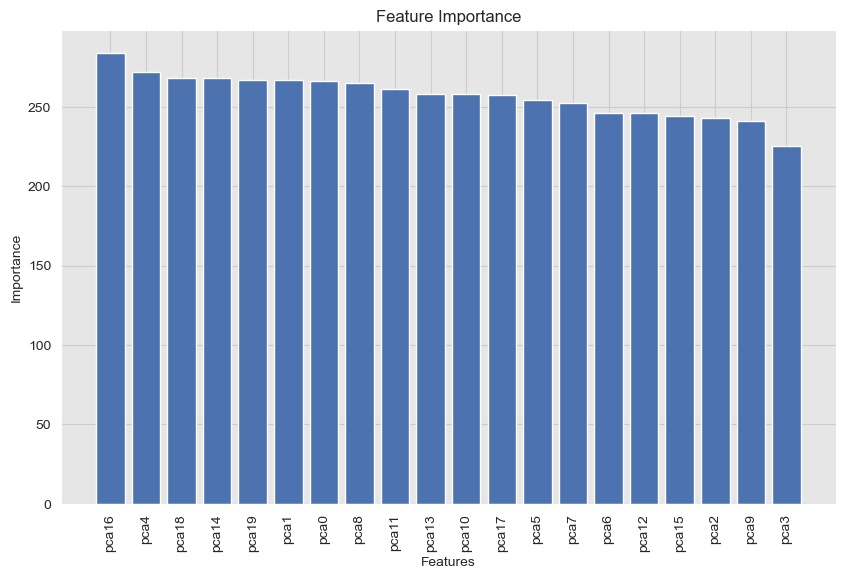

In [10]:
# Assuming you have trained your XGBoost classifier and stored it in xgb_model
importance = xgb_model.get_booster().get_score(importance_type='weight')
features = list(importance.keys())
importance_values = list(importance.values())

# Get feature importance using the provided function
feature_importance = get_feature_importance(features, importance_values)

# Print or return the sorted DataFrame
print(feature_importance)

plt = get_feature_importance_plot(
    feature_importance, modelname='XGB')
plt.show()


### Learning Curves Plot

show the training error (Ein) and validation error (Eval) as a function of the training set size


In [11]:
X_train_temp = X_train.copy()

In [12]:
imp_threshold = 5
for i in range(len(feature_importance)):
    if feature_importance['importance'][i] < imp_threshold:
        # remove the feature from the training data that has importance < imp_threshold
        X_train_temp = X_train_temp.drop(
            columns=feature_importance['feature'][i])
len(X_train_temp.columns)

20

In [13]:

cv_results = cross_validate(xgb.XGBClassifier(**params), X_train_temp, y_train, cv=NUM_FOLDS, scoring=[
                            'f1_macro', 'accuracy', 'f1_micro', 'f1_weighted'])

print('accuracy: ', cv_results['test_accuracy'].mean())
print('f1_macro: ', cv_results['test_f1_macro'].mean())
print('f1_micro: ', cv_results['test_f1_micro'].mean())
print('accuracy: ', cv_results['test_accuracy'].mean())
print('f1_macro: ', cv_results['test_f1_macro'].mean())
print('f1_micro: ', cv_results['test_f1_micro'].mean())


accuracy:  0.8991
f1_macro:  0.4744204067049787
f1_micro:  0.8991
accuracy:  0.8991
f1_macro:  0.4744204067049787
f1_micro:  0.8991


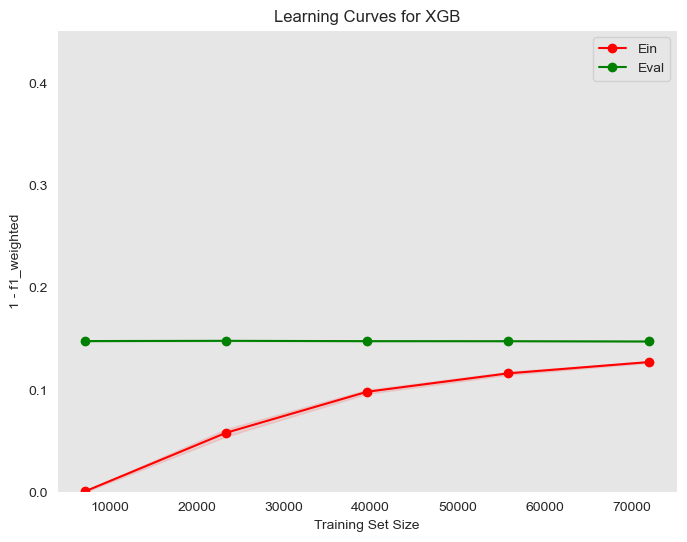

In [14]:
plt = get_learning_curve_plot(estimator=xgb.XGBClassifier(**params), X=X_train, y=y_train, cv=NUM_FOLDS, modelname='XGB')
plt.show()


### Partial Dependence Plot

A partial dependence plot shows the relationship between a feature and the model's predictions while holding all other features constant. It can be used to understand the impact of a single feature on the model's predictions i.e. PDPs show the average effect on predictions as the value of feature changes.

From the plots, we may see the type of the relationship between a feature and a prediction. Some relationships may look linear whereas other are more complex.


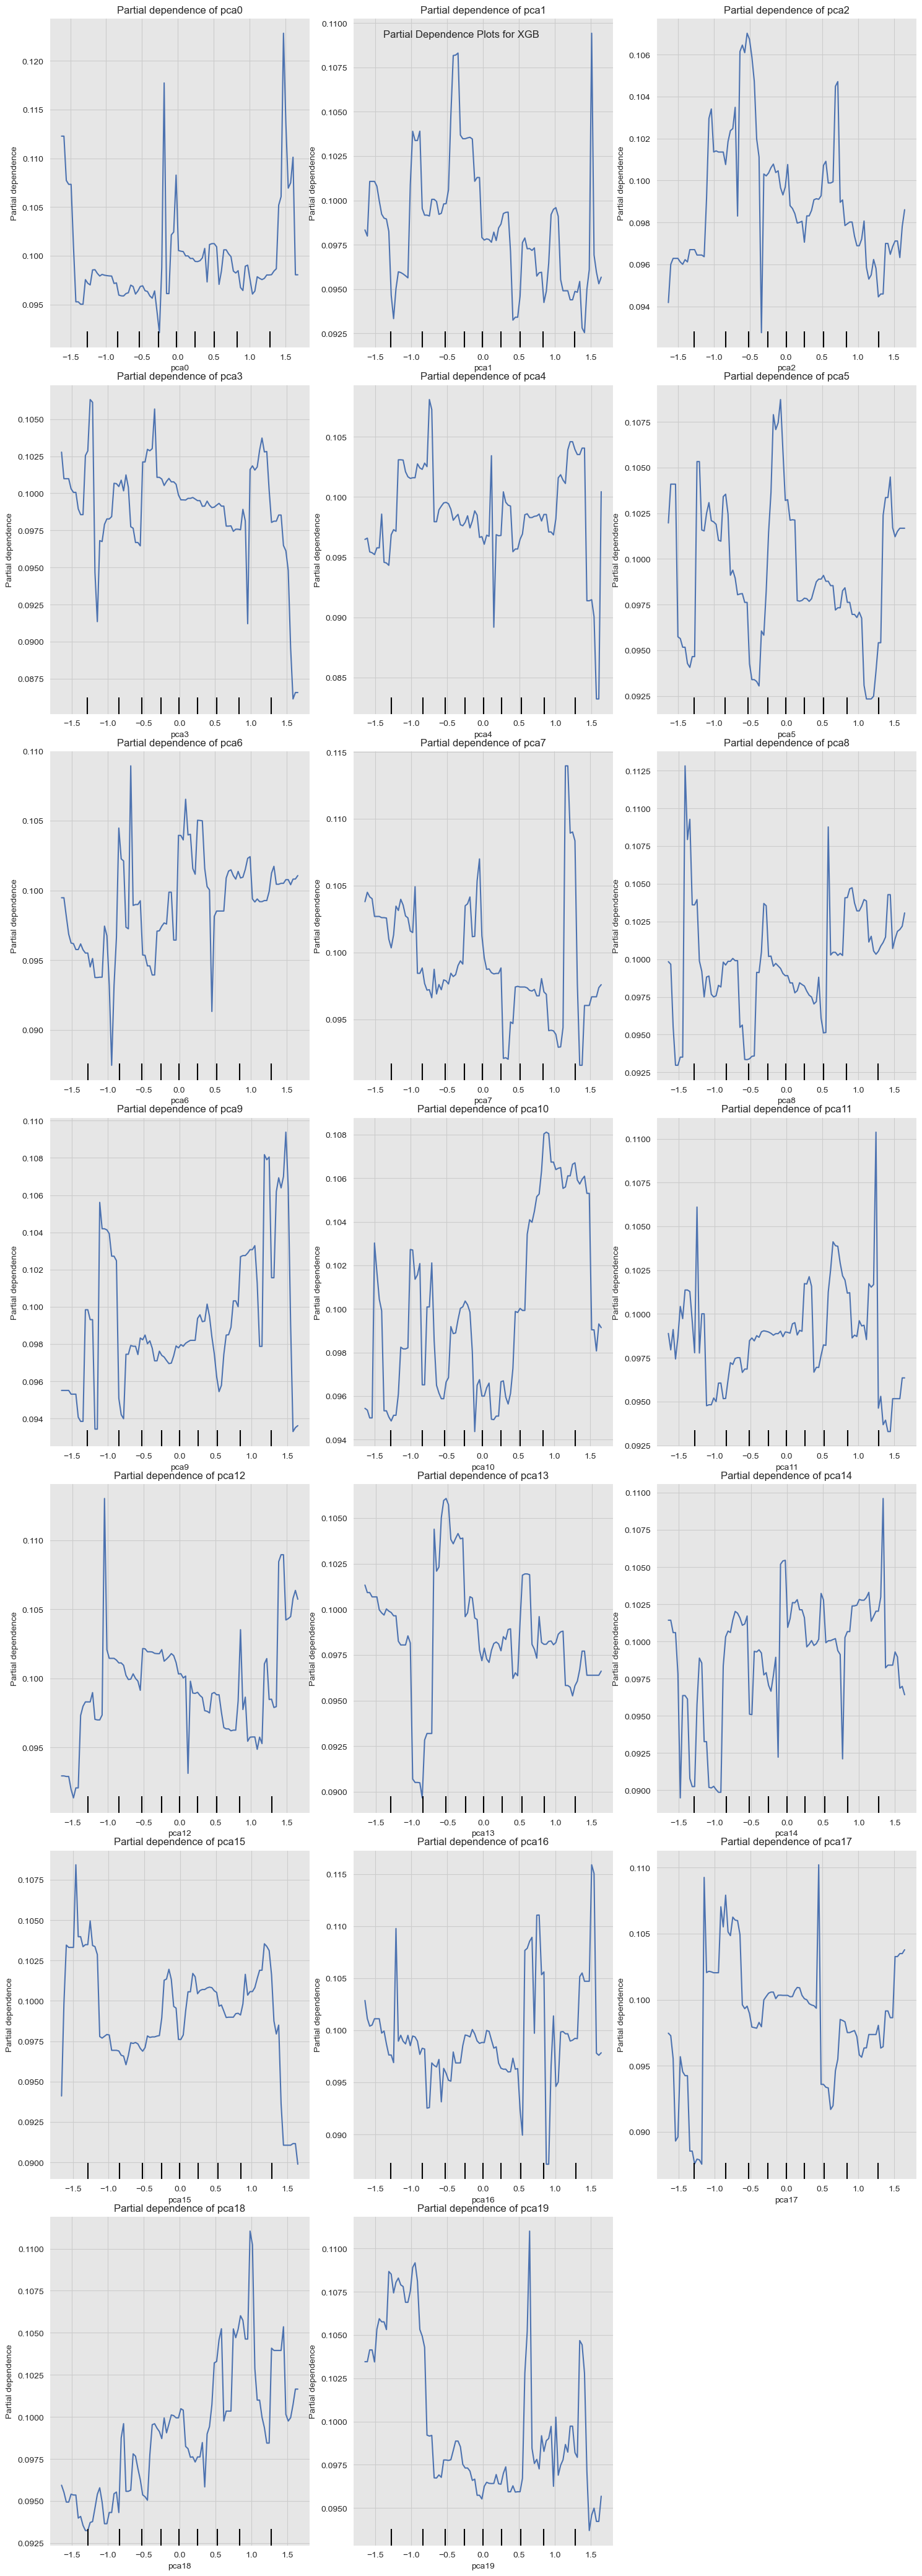

In [15]:
plt = get_partial_dependencies_plot(xgb_model, X_train, modelname='XGB', save=True)
plt.show()


### Hyperparameter Tuning

This is a process of adjusting the parameters of a model to optimize its performance. It can be done using techniques like grid search, random search, or Bayesian optimization.


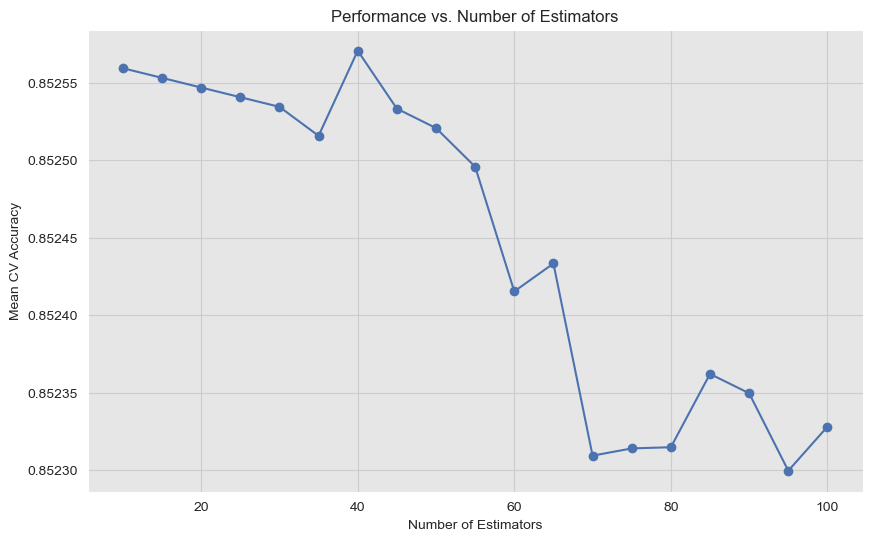

In [16]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score
# Define a range of n_estimators values to try
estimator_range = range(10, 101, 5)

# Initialize an empty list to store cross-validation scores
cv_scores = []

# Perform cross-validation for each value of n_estimators
for estimator in estimator_range:
    params_temp = {
    "device": "cuda",
    # "tree_method": "gpu_hist"
    "tree_method": "hist",
    "n_estimators": estimator
    }
    xgb_model = xgb.XGBClassifier(**params_temp)
    scores = cross_val_score(xgb_model, X_train, y_train, cv=NUM_FOLDS, scoring='f1_weighted')
    # print("Scores:", scores)
    cv_scores.append(scores.mean())

# Plot the performance curve
plt.figure(figsize=(10, 6))
plt.plot(estimator_range, cv_scores, marker='o', linestyle='-')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean CV Accuracy')
plt.title('Performance vs. Number of Estimators')
plt.grid(True)
plt.savefig(f'../images/XGB/number_estimators_effect.png', dpi=300, bbox_inches='tight')
plt.show()


In [17]:
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.1, 0.2, 0.3],
}


### Grid Search


In [18]:
model_name = 'XGB'
grid_search = get_grid_search(estimator=xgb.XGBClassifier(**params), param_grid=param_grid, X=X, y=y, cv=NUM_FOLDS, scoring='f1_weighted')
# Print the results
print("Best parameters found:", grid_search.best_params_)
print("Best score found:", grid_search.best_score_)
print("Test score with best parameters:", grid_search.score(X_test, y_test))


Best parameters found: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200}
Best score found: 0.8519475826477357
Test score with best parameters: 0.8519620990953821


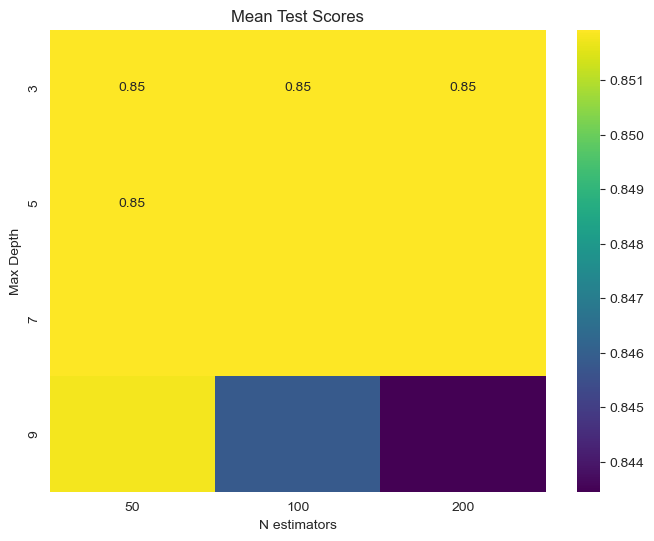

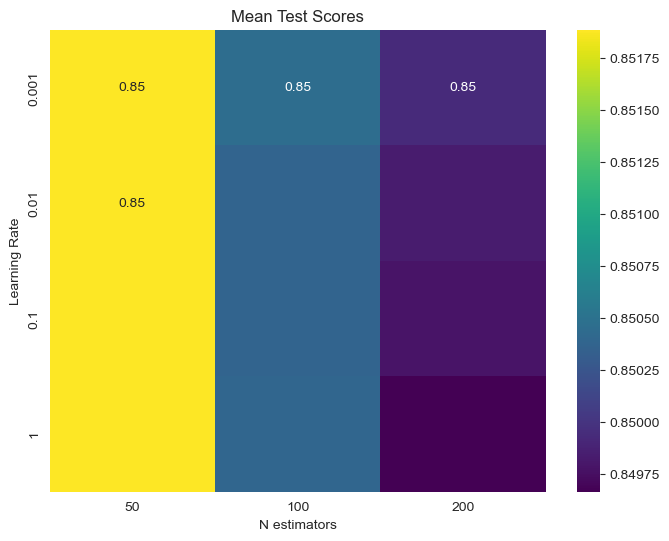

In [19]:
# Get the results
results = grid_search.cv_results_
mean_test_scores = results['mean_test_score']

# Prepare the hyperparameter values for plotting
param_values_lr = param_grid['learning_rate']
param_values_md = param_grid['max_depth']
param_values_ne = param_grid['n_estimators']
param_values_gm = param_grid['gamma']

# Reshape the mean test scores for plotting
mean_test_scores = np.array(mean_test_scores).reshape(len(param_values_lr), len(param_values_md), len(param_values_ne), len(param_values_gm))

# Create a plot
fig, ax = plt.subplots(figsize=(8, 6))
# Create a heatmap of mean test scores
sns.heatmap(mean_test_scores.mean(axis=0)[:,:,0], annot=True, cmap='viridis', xticklabels=param_values_ne, yticklabels=param_values_md)

# Set labels and title
plt.xlabel('N estimators')
plt.ylabel('Max Depth')
plt.title('Mean Test Scores')

# save the plot
plt.savefig(f'../images/{model_name}/mean_test_scores_1.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()
fig, ax = plt.subplots(figsize=(8, 6))

# Create a heatmap of mean test scores
sns.heatmap(mean_test_scores.mean(axis=1)[:,:,0], annot=True, cmap='viridis', xticklabels=param_values_ne, yticklabels=param_values_lr)

# Set labels and title
plt.xlabel('N estimators')
plt.ylabel('Learning Rate')
plt.title('Mean Test Scores')

# save the plot
plt.savefig(f'../images/{model_name}/mean_test_scores_2.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

### Heatmap


IndexError: index 4 is out of bounds for axis 0 with size 4

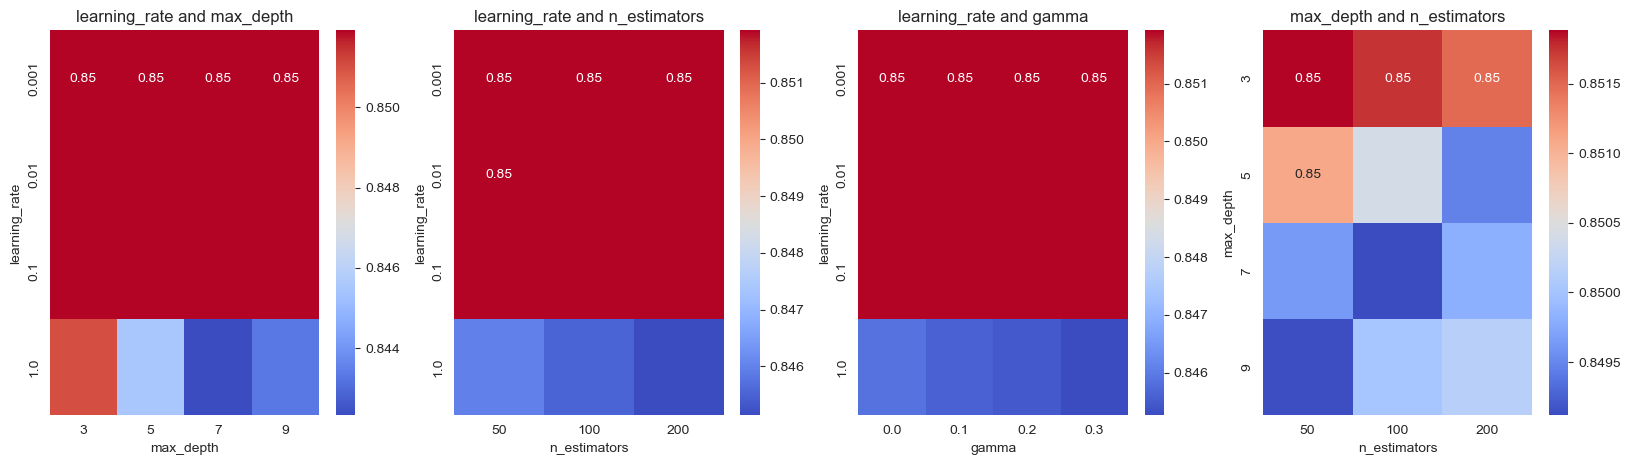

In [20]:
plot_hyper_param_heat_maps(param_grid, grid_search,modelname='XGB')


### Train-Validation Curve


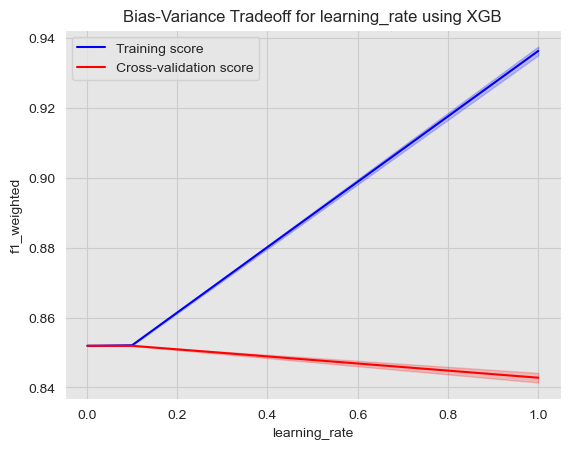

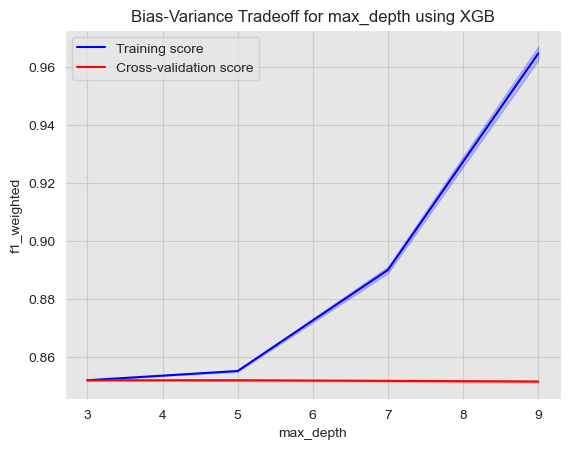

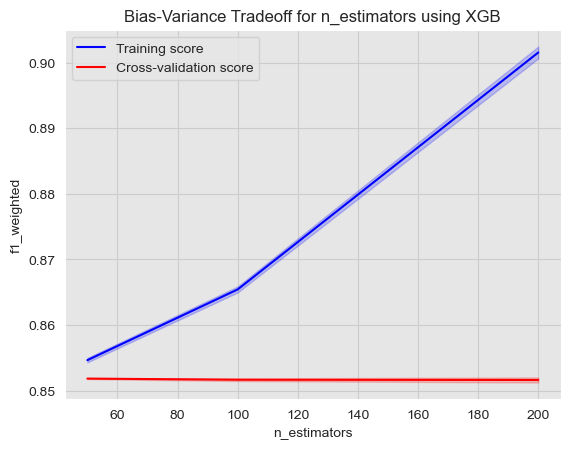

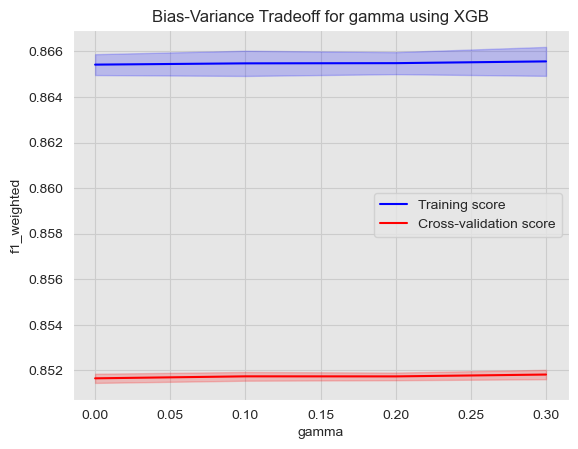

In [21]:
plot_hyper_param_train_validation_curve(estimator=xgb.XGBClassifier(**params), param_grid=param_grid, X=X, y=y, cv=NUM_FOLDS, scoring='f1_weighted', modelname='XGB')


accuracy:  0.8995199999999999
f1_macro:  0.47365033802031553
f1_micro:  0.8995199999999999
Accuracy Score of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) is: 0.89951


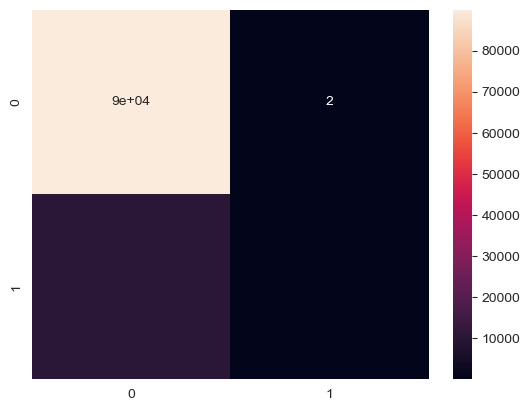

Classification Report of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) is: 
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     89951
           1       0.50      0.00      0.00     10049

    accuracy                           0.90    100000


In [22]:
# Add best params: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
best_params = {
    'device': 'cuda',
    'tree_method': 'hist',
    **grid_search.best_params_
}
xgb_model = xgb.XGBClassifier(**best_params)

# train the xgb_model
xgb_model.fit(X, y)
# validate the xgb_model
cv_results = cross_validate(xgb_model, X, y, cv=NUM_FOLDS, scoring=[
                            'f1_macro', 'accuracy', 'f1_micro', 'f1_weighted'])

print('accuracy: ', cv_results['test_accuracy'].mean())
print('f1_macro: ', cv_results['test_f1_macro'].mean())
print('f1_micro: ', cv_results['test_f1_micro'].mean())

# predict the validation set
y_pred = xgb_model.predict(X_test)

# Accuracy Score
print("Accuracy Score of " + str(xgb_model) + " is: " + str(accuracy_score(y_test, y_pred)))

# Confusion Matrix
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
# save the plot
plt.savefig(f'../images/{model_name}/evaluation_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
# Classification Report
print("Classification Report of " + str(xgb_model) + " is: \n" + str(classification_report(y_test, y_pred)))

# Weighted F1 Score
print("F1 Score of " + str(xgb_model) + " is: " + str(f1_score(y_test, y_pred, average='weighted')))

## Bias-Variance Analysis


In [23]:
xgb_model = xgb.XGBClassifier(**best_params)
mse, bias, var = get_bias_variance(
    xgb_model, X_train=X, y_train=y, X_test=X_test, y_test=y_test)


In [24]:
print("mse: ", mse)
print("bias: ", bias)
print("var: ", var)
print("Estimated Eout: ",bias + var)

mse:  0.10054305
bias:  0.10047600725000003
var:  6.704275e-05
Estimated Eout:  0.10054305000000002


AUC: 0.50


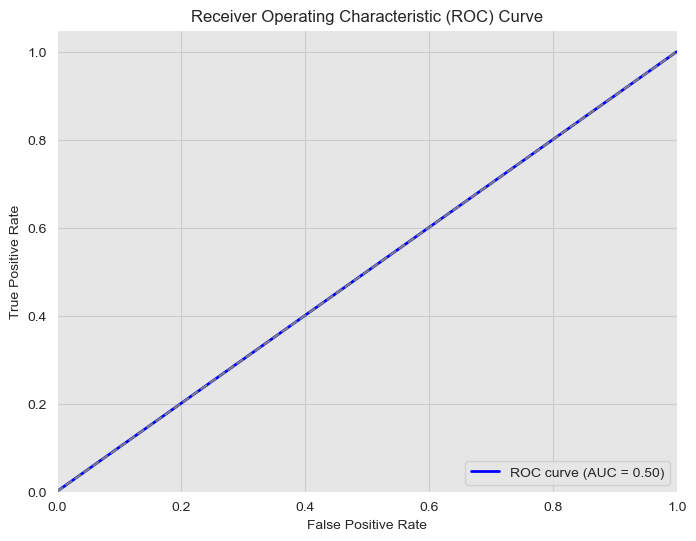

In [25]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc = roc_auc_score(y_test, y_pred)
print('AUC: %.2f' % roc_auc)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
# save
plt.savefig(f'../images/{model_name}/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()